# Notebook 4 - Modelagens
    
    -> Pipeline para busca de hiperparmetros (features selection entra como parametro)
    -> tranformar em script e rodar no nó c6 pelo slurm
    -> Testar n sub bases e n modelos, fazer funcao para isso, talvez usar pipeline

## Ambiente

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from lightgbm import LGBMRegressor, plot_tree
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time
import shap 
from sklearn import tree

## Dados

In [2]:
Xy = pd.read_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Xy_Voxels_665.parquet")
Xy = Xy.rename(columns={'thickness':'curv', 'curv':'thickness'})

In [3]:
main = ['participant', 'thickness', 'age', 'structure']

geometrics =['area', 'curv', 'sulc']

atlas = ['atlasDF', 'atlasEcono']

basic =['hemisphere', 'sex', 'handedness']

basic_dummies =['hemisphere_left', 'sex_FEMALE']

structure_dummies =['structure_FA', 'structure_FB', 'structure_FC', 'structure_FCBm',
                    'structure_FD', 'structure_FDT', 'structure_FDdelta', 'structure_FE',
                    'structure_FF', 'structure_FG', 'structure_FH', 'structure_FJK',
                    'structure_IA', 'structure_IB', 'structure_LA1', 'structure_LA2',
                    'structure_LC1', 'structure_LC2', 'structure_LC3', 'structure_LD',
                    'structure_OA', 'structure_OB', 'structure_OC', 'structure_PA',
                    'structure_PB', 'structure_PC', 'structure_PD', 'structure_PE',
                    'structure_PF', 'structure_PG', 'structure_PH', 'structure_TA',
                    'structure_TB', 'structure_TC', 'structure_TD', 'structure_TE',
                    'structure_TF', 'structure_TG']

bb1 =['ve_1','ve_2', 've_3', 've_4', 've_5', 've_6']

bb2 =['ve1_age', 've2_age', 've3_age','ve4_age', 've5_age', 've6_age']

bb3 =['bigbrain_layer_1','bigbrain_layer_2', 'bigbrain_layer_3',
      'bigbrain_layer_4','bigbrain_layer_5', 'bigbrain_layer_6']

bb4 =['bblayer1_age', 'bblayer2_age', 'bblayer3_age', 
      'bblayer4_age','bblayer5_age', 'bblayer6_age'] 


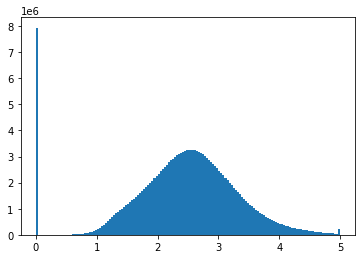

In [4]:
plt.hist(Xy.thickness, bins = 150)
plt.show()

In [5]:
print(str(round(len(Xy.query('thickness == 0'))*100/len(Xy),1))+'% voxels thickness are zeros')

4.5% voxels thickness are zeros


## Train Test Split

##### Criando sub amostra com N participantes

In [6]:
participants_list0 = Xy.participant.unique()
participants_test0 = random.sample(list(participants_list0), 100)
sample = Xy[Xy.participant.isin(participants_test0)]
sample = sample.drop(columns = basic)

##### Dropando voxels thickness are zeros

In [7]:
sample = sample[sample['thickness'].astype(bool)]

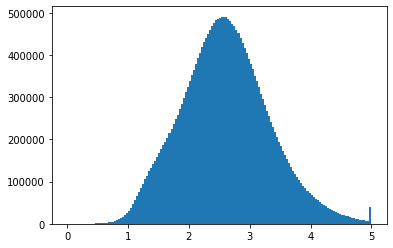

In [8]:
plt.hist(sample.thickness, bins = 150)
plt.show()

##### Separando Treino e Teste 20%

In [9]:
n_test = int(len(participants_test0)*0.2)
participants_test = random.sample(list(participants_test0), n_test)

In [10]:
Xy_test = sample[sample.participant.isin(participants_test)]
Xy_train = sample[~sample.participant.isin(participants_test)]
print('length train: ' + str(len(Xy_train)))
print('length test:  ' + str(len(Xy_test)))

length train: 20156920
length test:  5147555


##### Criando Base por Voxels

In [11]:
X_train_vo = Xy_train.drop(columns = ['participant', 'thickness', 'structure']) 
X_test_vo = Xy_test.drop(columns = ['participant', 'thickness', 'structure']) 
y_train_vo = Xy_train.thickness
y_test_vo = Xy_test.thickness

##### Criando Base Agrupada

In [12]:
# treino
list_g = []
for i, participant in enumerate(Xy_train.participant.unique()):
    df_g = Xy_train[Xy_train.participant == participant].groupby(['structure']).mean()
    list_g.append(df_g)
    
Xy_train_gr = pd.concat(list_g) 
Xy_train_gr = Xy_train_gr.reset_index(drop=True)
X_train_gr = Xy_train_gr.drop(columns='thickness')
y_train_gr = Xy_train_gr.thickness

# test
list_g = []
for i, participant in enumerate(Xy_test.participant.unique()):
    df_g = Xy_test[Xy_test.participant == participant].groupby(['structure']).mean()
    list_g.append(df_g)
    
Xy_test_gr = pd.concat(list_g) 
Xy_test_gr = Xy_test_gr.reset_index(drop=True)
X_test_gr = Xy_test_gr.drop(columns='thickness')
y_test_gr = Xy_test_gr.thickness

## Modelos: Treino, Peformance e Explicabilidade 

In [13]:
def model(voxel = False,
          structure_selection = 0,
          features = ['age'] + geometrics + basic_dummies + structure_dummies + bb1 + bb2 + bb3 + bb4, 
          scatter = True,
          expli = True,
          resume = True,
          categorical_feature = []
         ):
    
    # parametros
    if voxel:
        model_type = 'Voxels'
        alpha_scatter = 0.1
        X_train = X_train_vo[features]
        X_test = X_test_vo[features]
        y_train = y_train_vo
        y_test = y_test_vo
    else:
        model_type = 'Regioes Corticais'
        alpha_scatter = 0.8
        X_train = X_train_gr[features]
        X_test = X_test_gr[features]
        y_train = y_train_gr
        y_test = y_test_gr
    
    if structure_selection != 0:
        index_train = X_train_gr.atlasEcono == structure
        index_test = X_train_gr.atlasEcono == structure
        X_train = X_train[index_train]
        X_test = X_test[index_test]
        y_train = y_train[index_train]
        y_test = y_test[index_test]
        
    # treino
    reg = LGBMRegressor(n_jobs=30, categorical_feature = categorical_feature).fit(X_train, y_train)
    if resume:
        print('- Objetivo: Prever a espessura de '+ model_type +'\n\n'+
              '- Features: '+ ', '.join(map(str, features)) +'\n\n'+
              '- Algoritmo: LGBMRegressor'+'\n\n'+
              '- Base de Dados: '+ str(len(participants_test))+ 
              ' individuos que geram '+ str(len(X_test)+len(X_train))+' '+model_type+' - 80% treino e 20% teste\n\n'
             )
    else:
        print('- Features: '+ ', '.join(map(str, features)) +'\n')
        
    
    # test
    y_pred = reg.predict(X_test)
    r2 = round(r2_score(y_test, y_pred),2)
    if scatter:
        plt.figure(figsize=[8,8])
        plt.title('R2 = '+str(r2))
        plt.xlabel("true")
        plt.ylabel("prediction")
        plt.scatter(y_test,y_pred,alpha = alpha_scatter)
        plt.show()
    else:
        return r2

    # explicabilidade
    if expli: 
        shap_values = shap.TreeExplainer(reg).shap_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type="bar")
        plt.figure()
        shap.summary_plot(shap_values, X_test)
        
        plot_tree(reg, figsize = (30,30), show_info = ['split_gain', 
                                                       'internal_value', 
                                                       'internal_count',
                                                       'data_percentage',
                                                       'leaf_count',
                                                      ])

#### Modelo 1.0 
- Nivel: Voxels 
- Variaveis: age + geometrics + basic_dummies + structure_dummies + bb1 + bb3

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


- Objetivo: Prever a espessura de Voxels

- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6

- Algoritmo: LGBMRegressor

- Base de Dados: 20 individuos que geram 25304475 Voxels - 80% treino e 20% teste




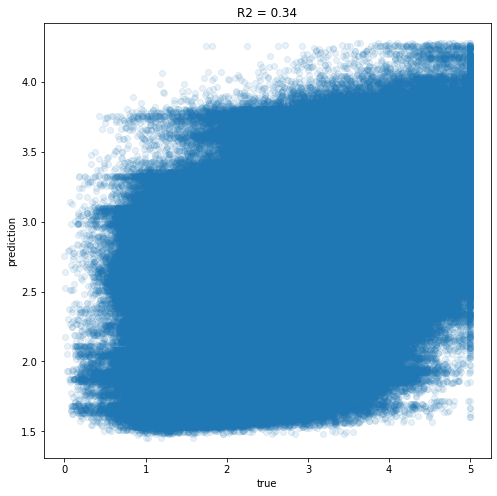

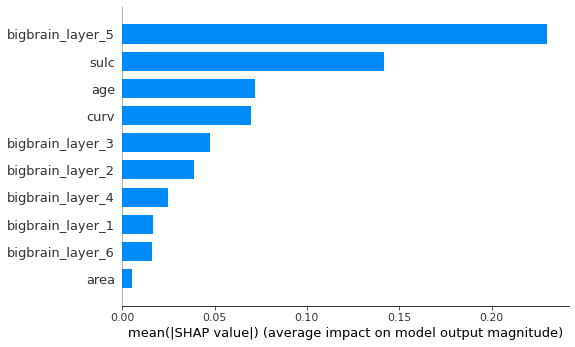

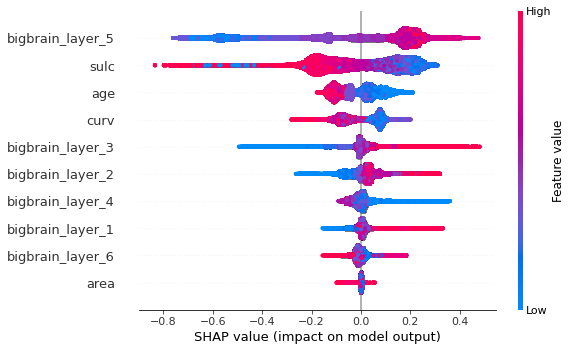

OSError: [Errno 12] Cannot allocate memory

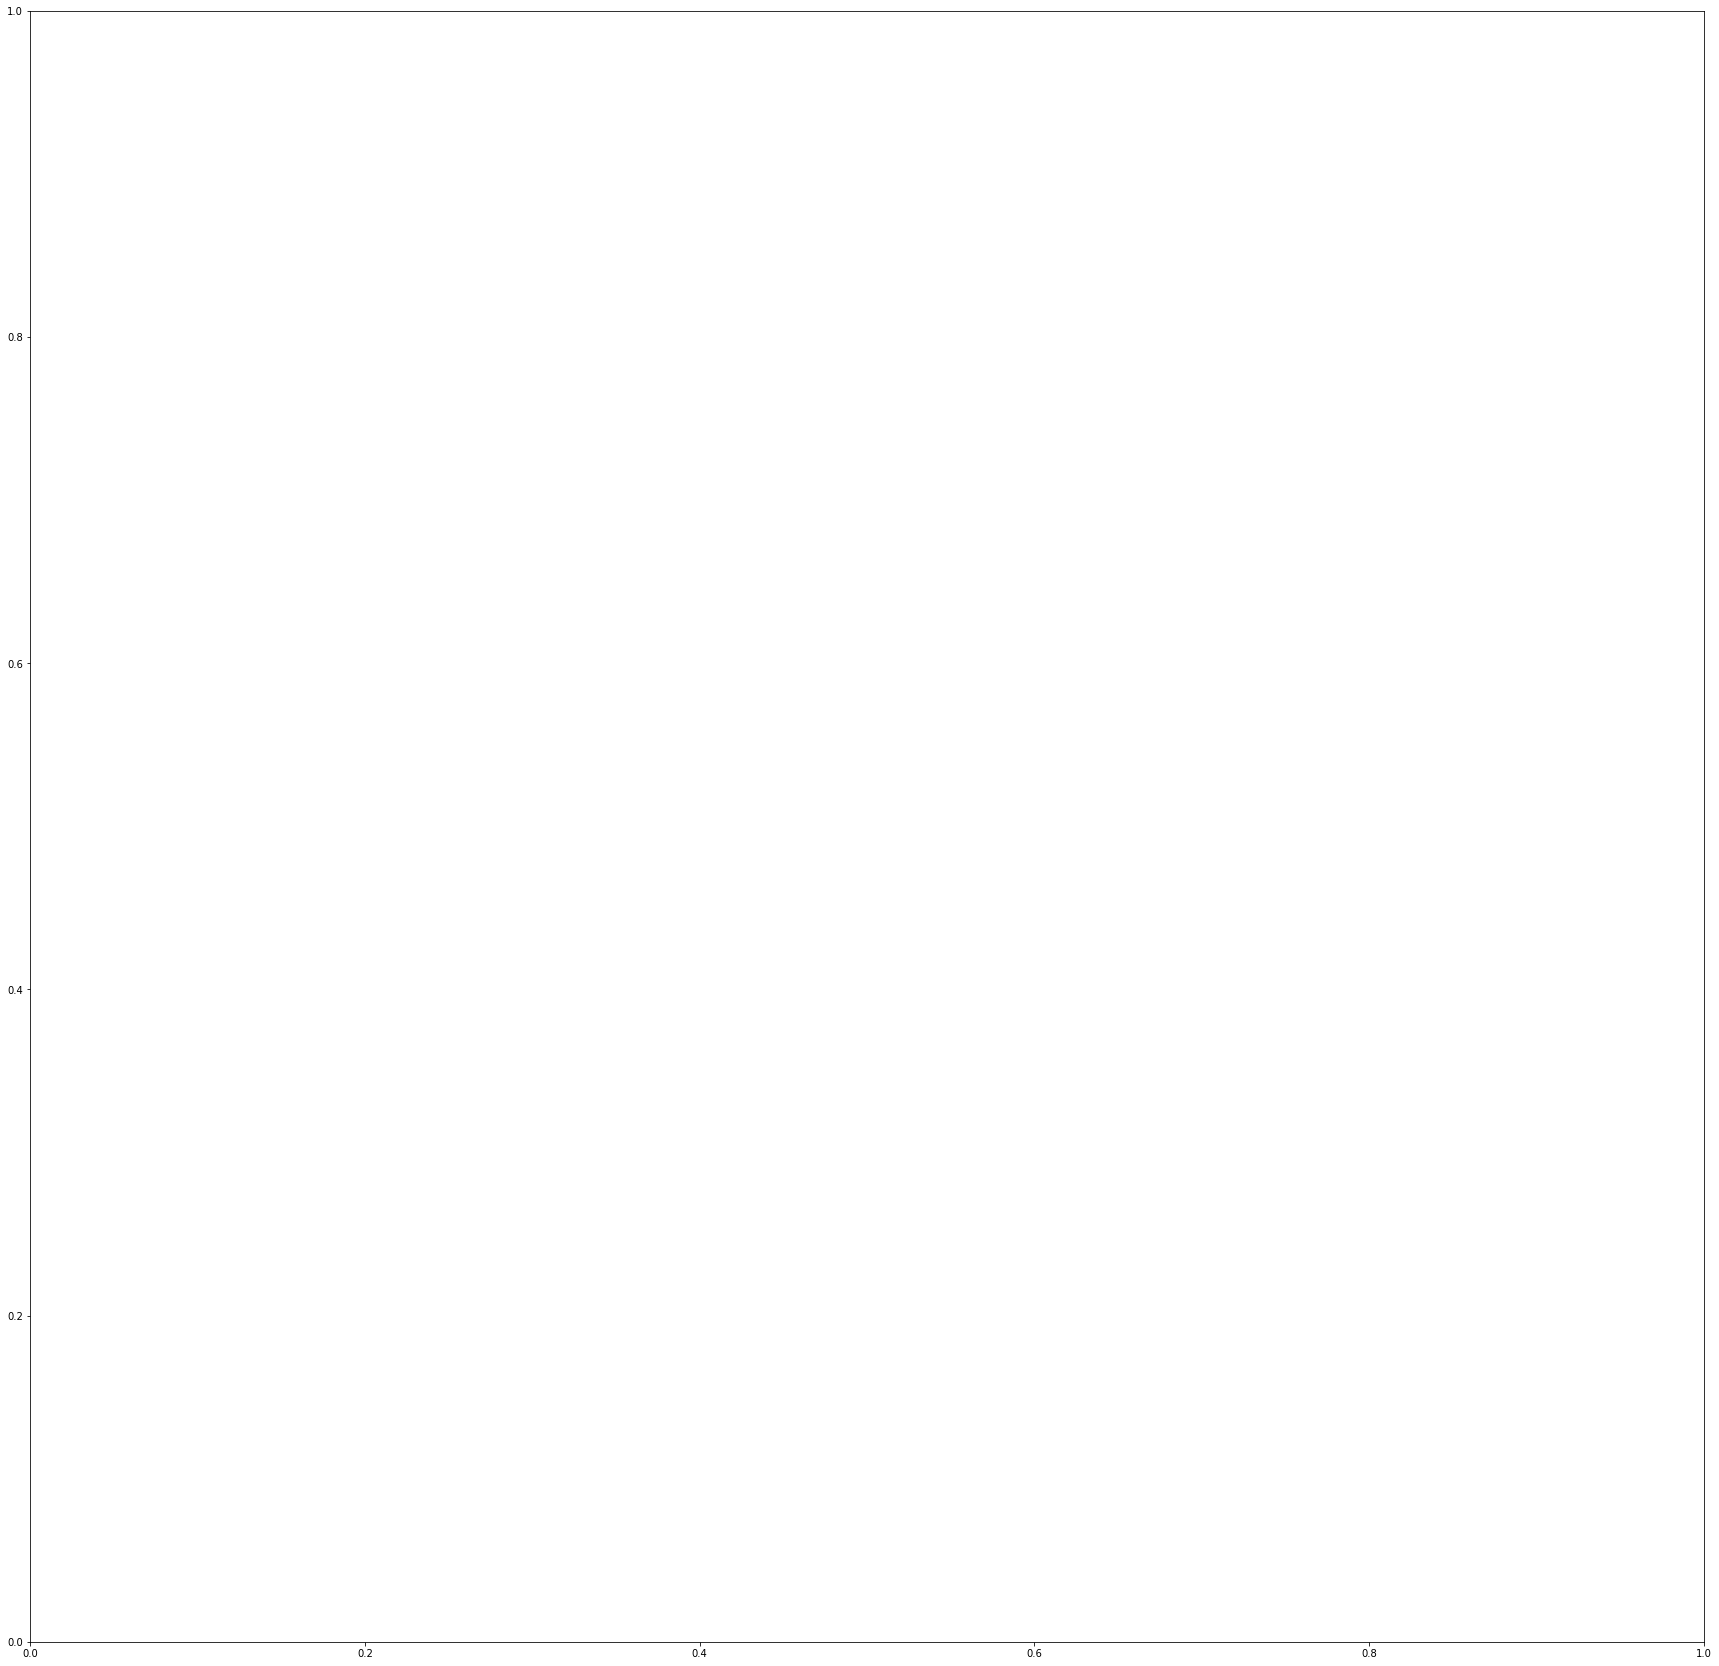

In [14]:
model(voxel = True, features = ['age'] + geometrics + bb3, categorical_feature=[1,2])

#### Modelo 1.1 
- Nivel: Voxels com agrupamento na avaliação 
- Variaveis: geometrics + basic_dummies + structure_dummies + bb1 + bb3

In [15]:
Xy_av = Xy_test_vo[['participant','structure','thickness']]
Xy_av['thickness_pred'] = y_pred

list_groupby = []
for i, participant in enumerate(Xy_av.participant.unique()):
    df_av = Xy_av[Xy_av.participant == participant].groupby(['structure']).mean()
    df_av['participant_i'] = i
    df_av['participant'] = participant
    list_groupby.append(df_av)
Xy_groupby = pd.concat(list_groupby)   

plt.figure(figsize=[8,8])
plt.title('Modelo com Voxel com Agrupamento na Avaliação: R2 = '+str(round(r2_score(Xy_groupby.thickness, Xy_groupby.thickness_pred),2)))
plt.scatter(Xy_groupby.thickness, 
            Xy_groupby.thickness_pred)
plt.show()

plt.figure(figsize=[8,8])
plt.title('Modelo com Voxel com Agrupamento na Avaliação: R2 = '+str(round(r2_score(Xy_groupby.thickness, Xy_groupby.thickness_pred),2)))
plt.scatter(Xy_groupby.thickness, 
            Xy_groupby.thickness_pred, 
            c = Xy_groupby.participant_i, 
            cmap = 'Set1'
           )
plt.show()

NameError: name 'Xy_test_vo' is not defined

#### Modelo 2.0
- Nivel: Agrupado 
- Variaveis: age + geometrics + bb3

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


- Objetivo: Prever a espessura de Regioes Corticais

- Features: age, atlasEcono

- Algoritmo: LGBMRegressor

- Base de Dados: 20 individuos que geram 3800 Regioes Corticais - 80% treino e 20% teste




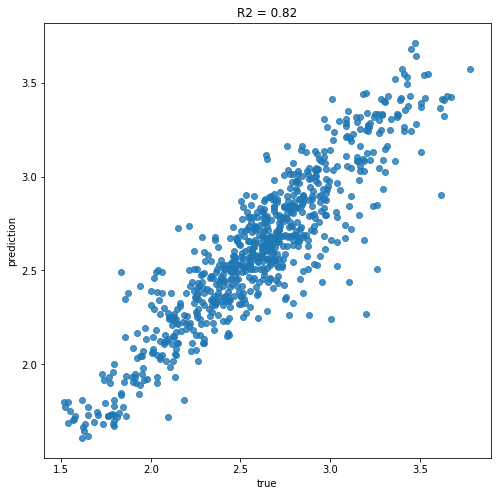

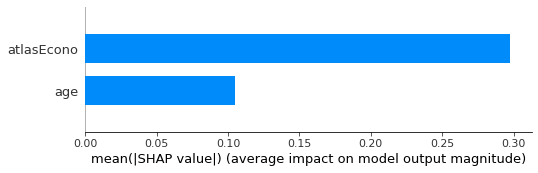

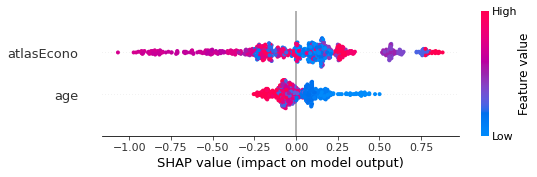

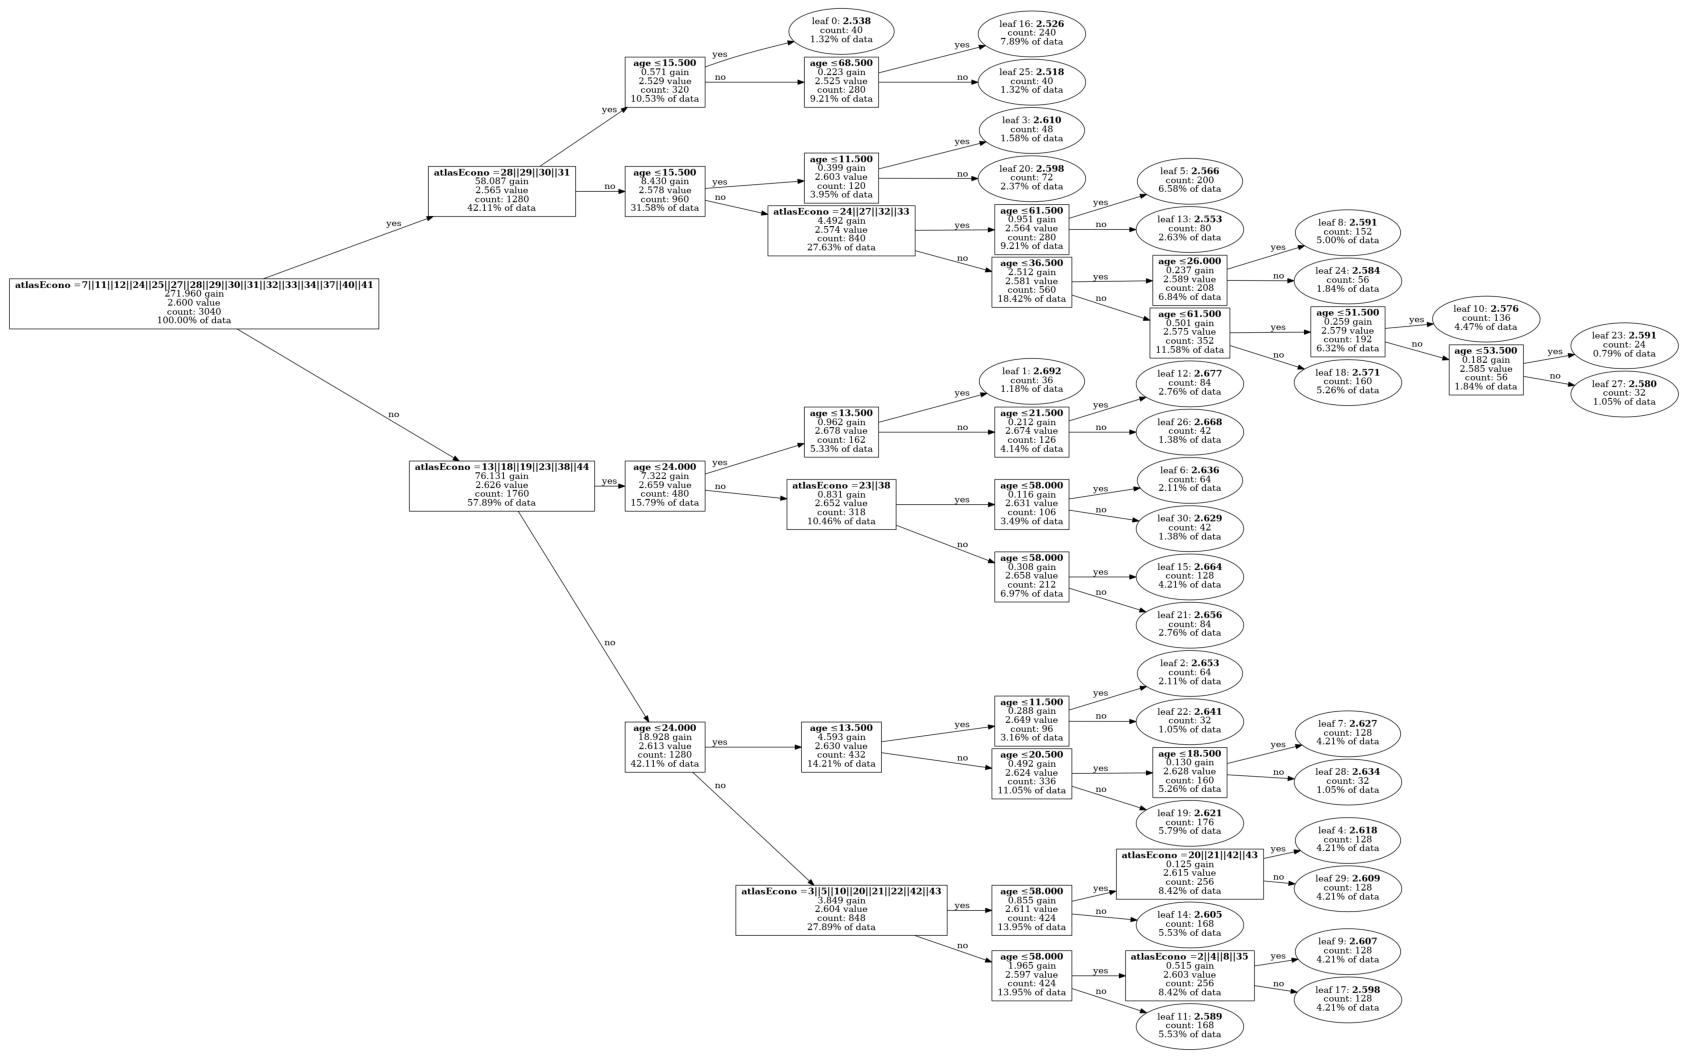

In [32]:
model(features = ['age'] + [atlas[1]], categorical_feature=[1]) #+ bb3 + geometrics

#### Modelo 2.N
- Nivel: Agrupado 
- Variaveis: permutacoes de todas

In [18]:
features_set = [['age'], [geometrics[0]], [geometrics[1]], [geometrics[2]], 
                geometrics, [atlas[0]], [atlas[1]],atlas, basic_dummies,structure_dummies, bb1, bb2, bb3, bb4,
                
                ['age']+bb1,
                ['age']+bb3,
                bb1+bb3,
                ['age']+geometrics+bb1,
                ['age']+basic_dummies+bb1,
                ['age']+geometrics+bb3,
                ['age']+basic_dummies+bb3,
                ['age']+geometrics+basic_dummies+bb1,
                ['age']+geometrics+basic_dummies+bb2,
                geometrics+basic_dummies+bb2,
                ['age']+geometrics+basic_dummies+bb3,
                ['age']+geometrics+basic_dummies+bb4,
                geometrics+basic_dummies+bb4,
                ['age']+ geometrics+ basic_dummies+ structure_dummies,
                ['age']+ geometrics+ basic_dummies+ structure_dummies+bb3,
                ['age']+ geometrics+ basic_dummies+ structure_dummies+bb1
               ]
for i, f in enumerate(features_set):
    print(i)
    r2 = model(features = f, scatter=False, expli=False, resume=False)
    print('- r2: '+str(r2)+'\n\n')

0
- Features: age

- r2: 0.02


1
- Features: area, curv, sulc

- r2: 0.4


2
- Features: atlasDF

- r2: 0.38


3
- Features: atlasEcono

- r2: 0.7


4
- Features: atlasDF, atlasEcono

- r2: 0.68


5
- Features: hemisphere_left, sex_FEMALE

- r2: -0.06


6
- Features: structure_FA, structure_FB, structure_FC, structure_FCBm, structure_FD, structure_FDT, structure_FDdelta, structure_FE, structure_FF, structure_FG, structure_FH, structure_FJK, structure_IA, structure_IB, structure_LA1, structure_LA2, structure_LC1, structure_LC2, structure_LC3, structure_LD, structure_OA, structure_OB, structure_OC, structure_PA, structure_PB, structure_PC, structure_PD, structure_PE, structure_PF, structure_PG, structure_PH, structure_TA, structure_TB, structure_TC, structure_TD, structure_TE, structure_TF, structure_TG

- r2: 0.7


7
- Features: ve_1, ve_2, ve_3, ve_4, ve_5, ve_6

- r2: 0.7


8
- Features: ve1_age, ve2_age, ve3_age, ve4_age, ve5_age, ve6_age

- r2: 0.47


9
- Features: bigbrain_layer_1

### Modelo 3

2.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


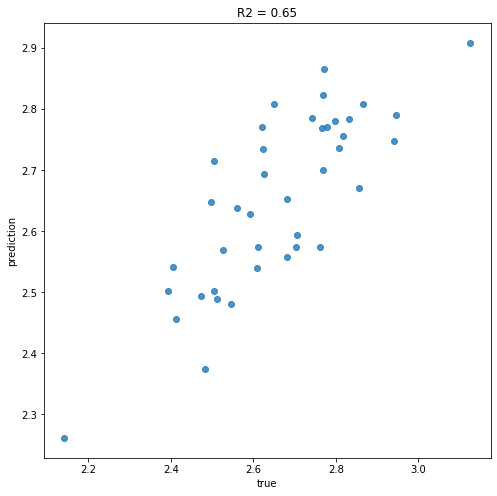

r2 : None
cor: -0.63
3.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


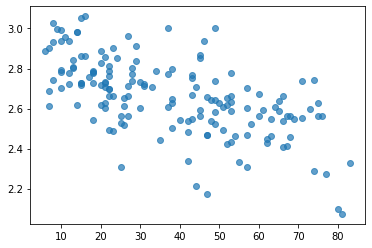

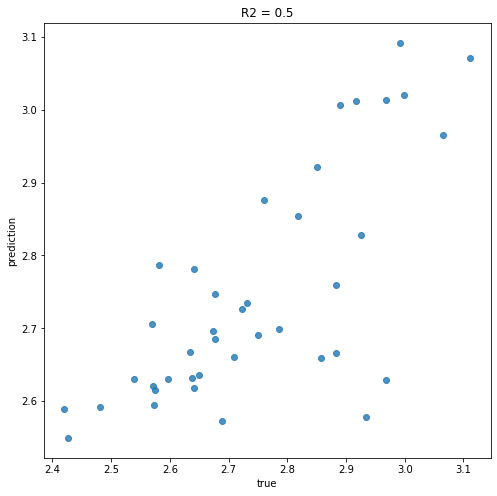

r2 : None
cor: -0.8
4.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


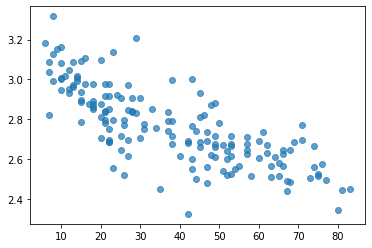

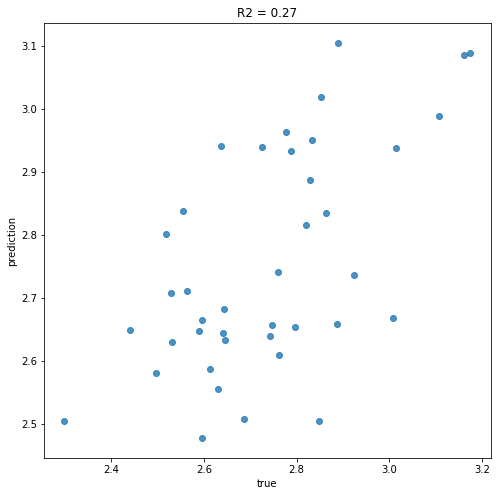

r2 : None
cor: -0.79
5.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


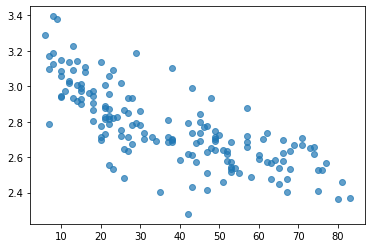

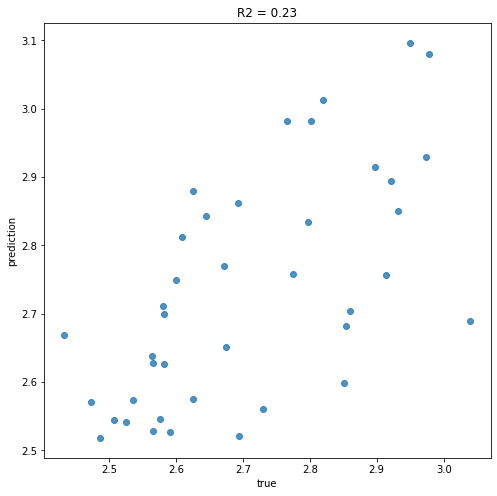

r2 : None
cor: -0.79
6.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


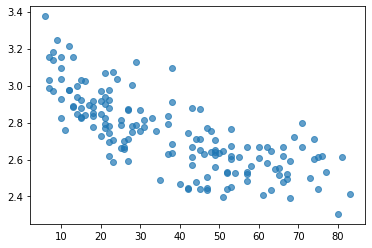

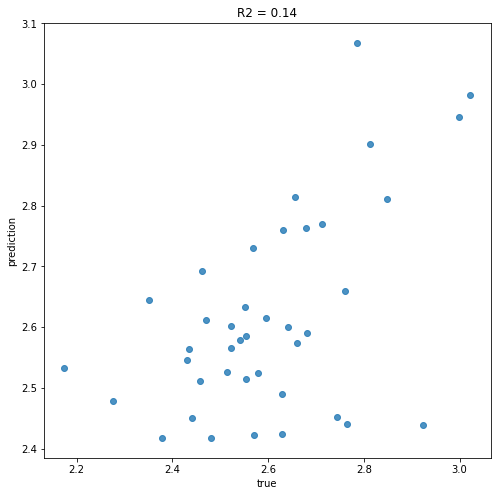

r2 : None
cor: -0.7
7.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


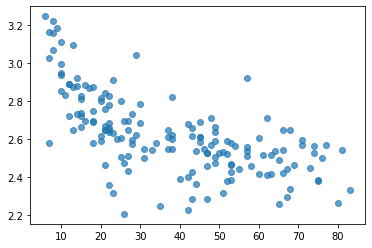

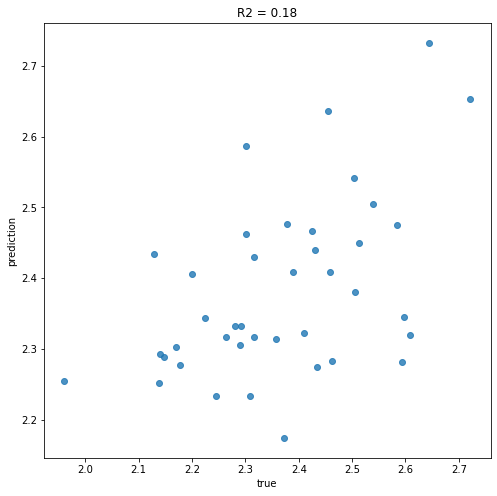

r2 : None
cor: -0.56
8.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


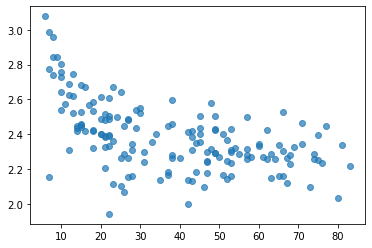

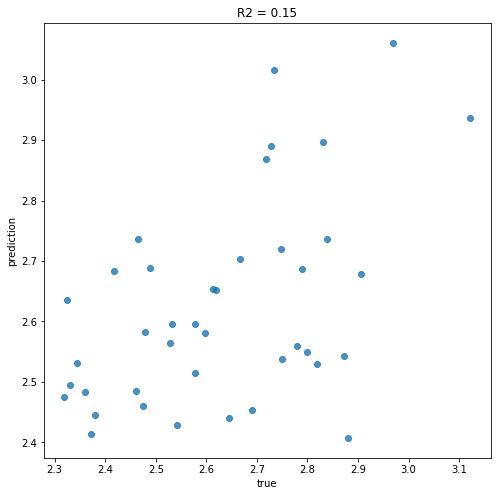

r2 : None
cor: -0.75
9.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


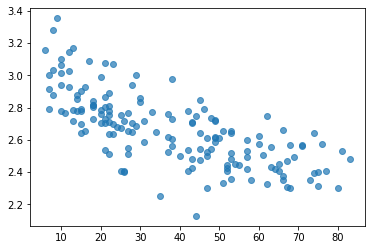

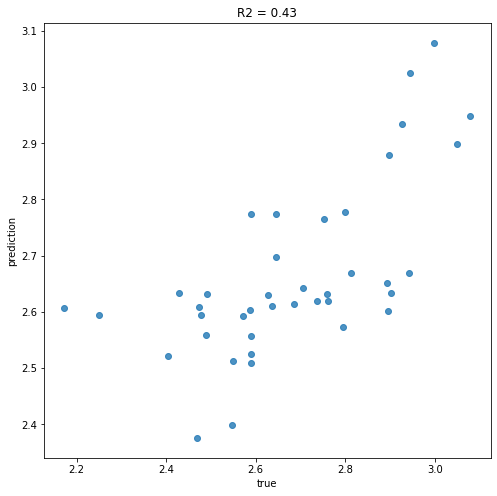

r2 : None
cor: -0.48
10.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


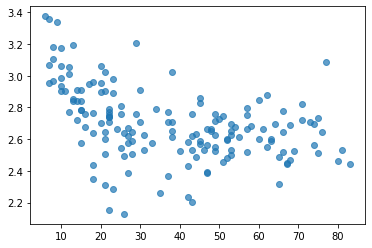

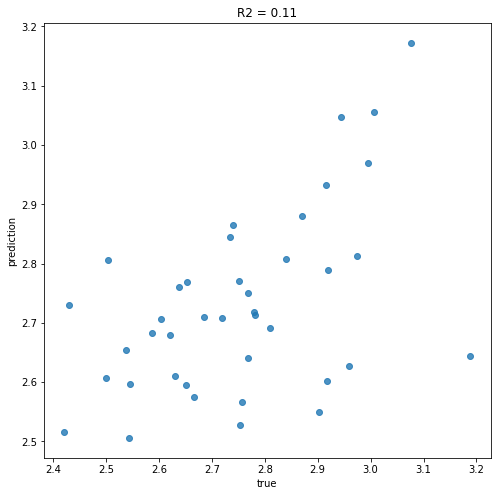

r2 : None
cor: -0.63
11.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


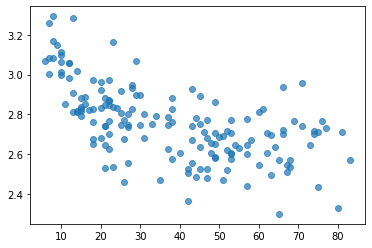

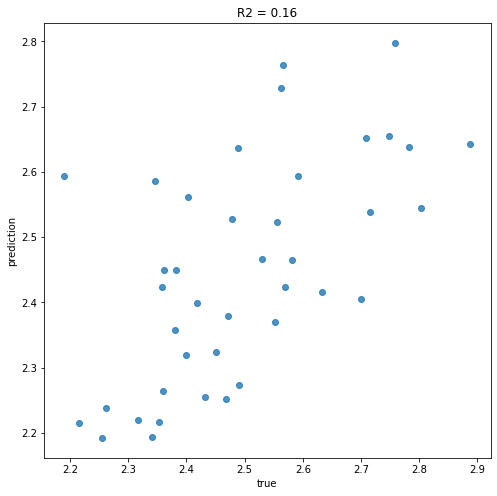

r2 : None
cor: -0.57
12.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


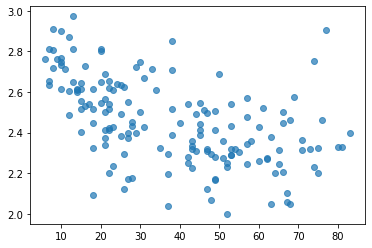

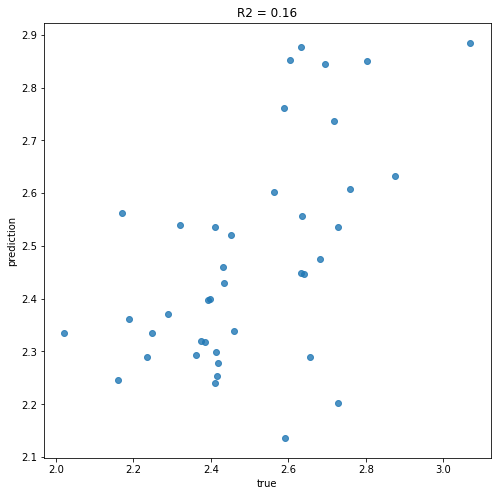

r2 : None
cor: -0.62
13.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


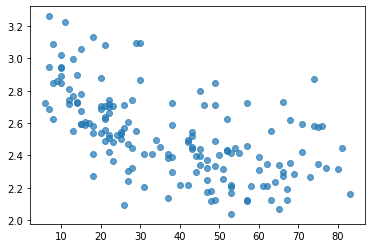

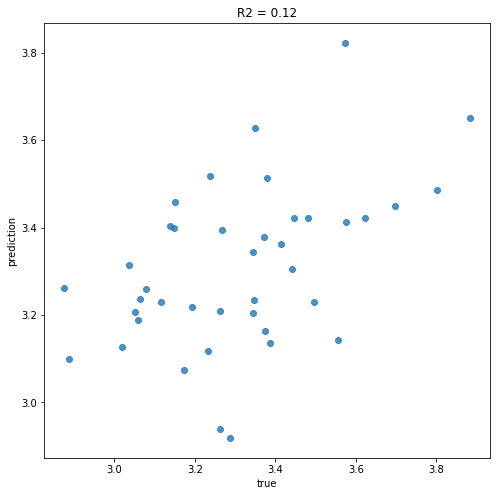

r2 : None
cor: -0.58
18.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


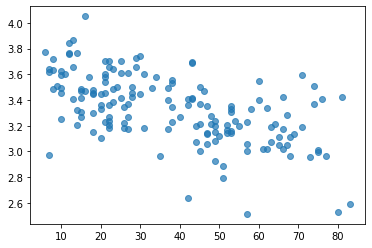

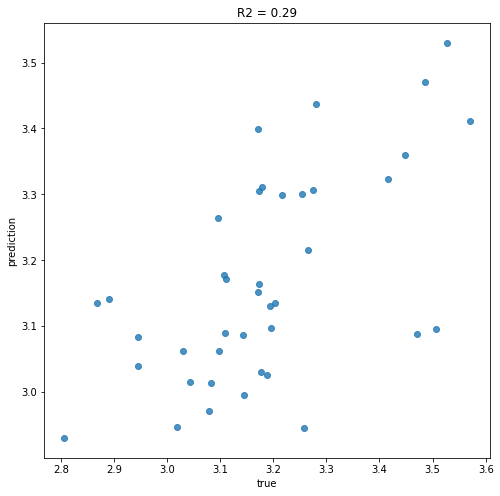

r2 : None
cor: -0.74
19.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


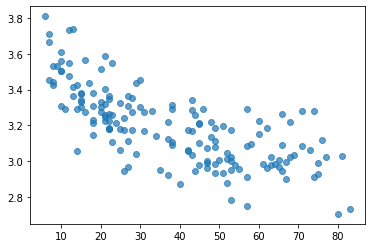

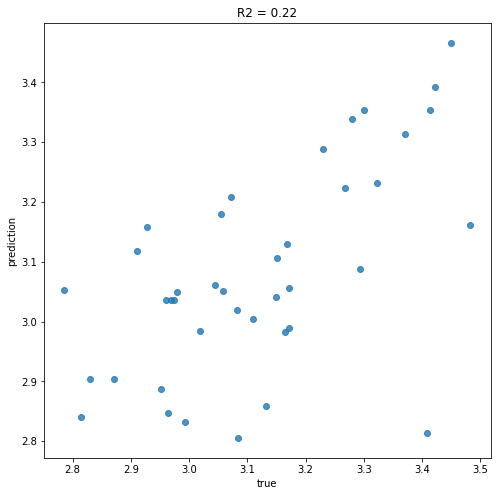

r2 : None
cor: -0.67
20.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


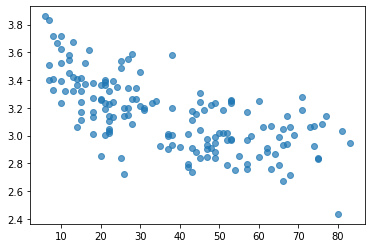

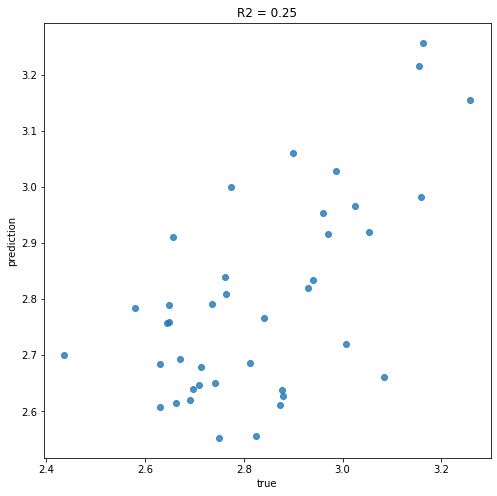

r2 : None
cor: -0.75
21.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


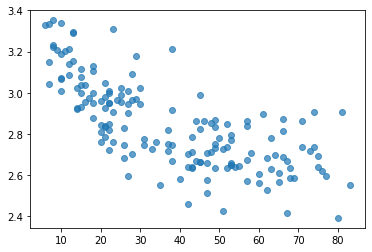

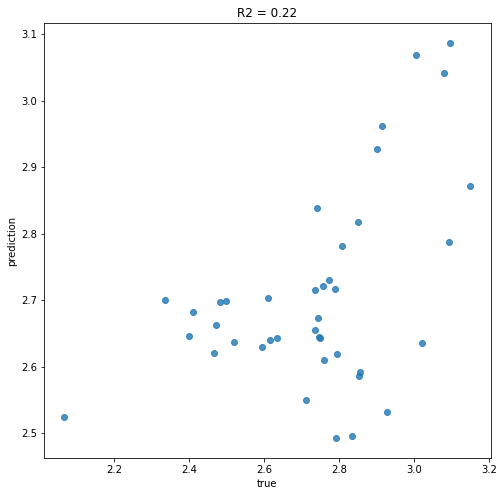

r2 : None
cor: -0.57
22.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


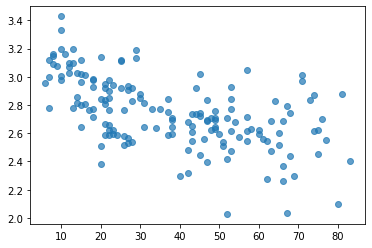

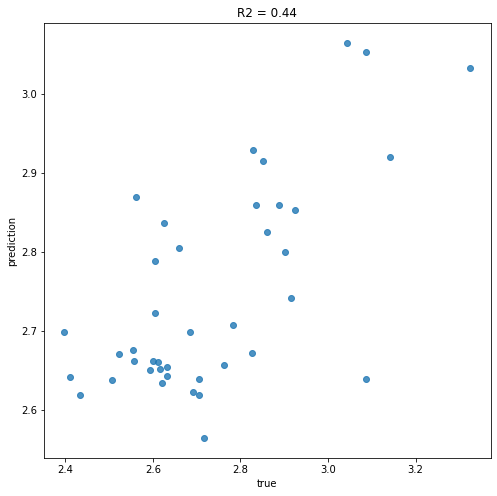

r2 : None
cor: -0.73
23.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


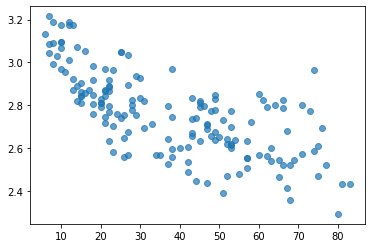

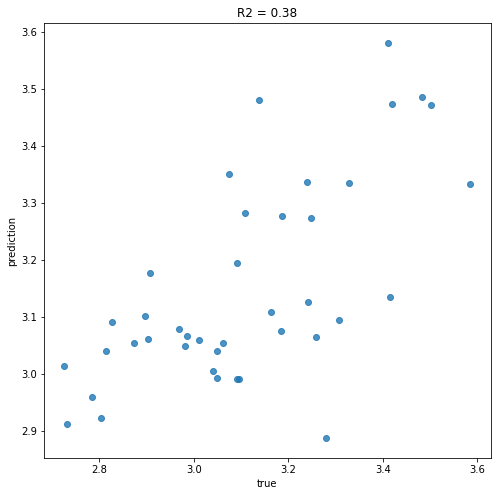

r2 : None
cor: -0.69
24.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


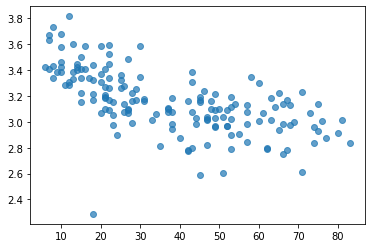

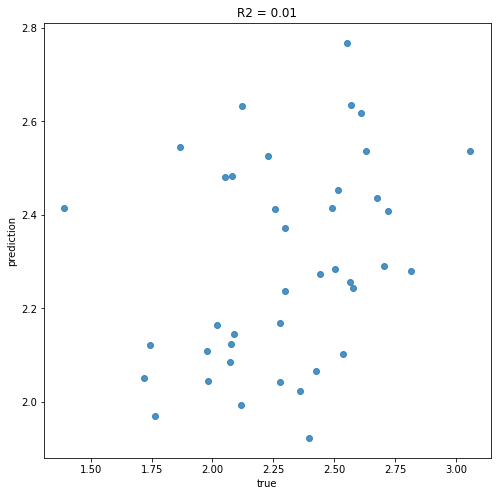

r2 : None
cor: -0.24
25.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


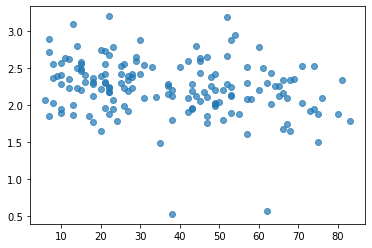

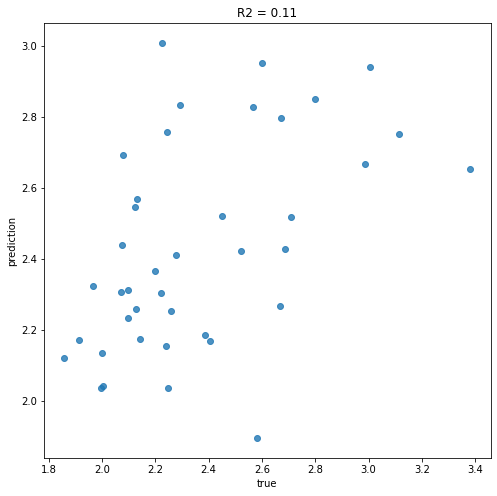

r2 : None
cor: -0.45
27.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


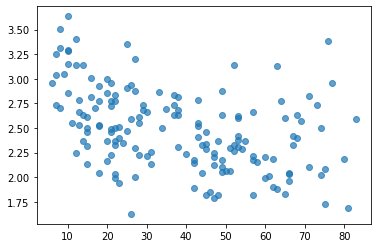

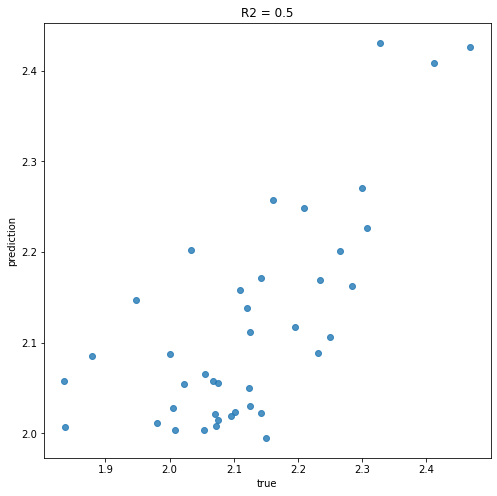

r2 : None
cor: -0.58
28.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


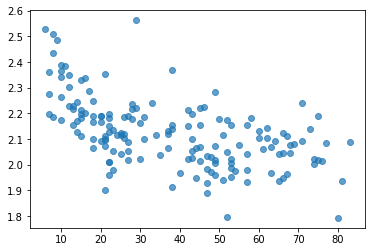

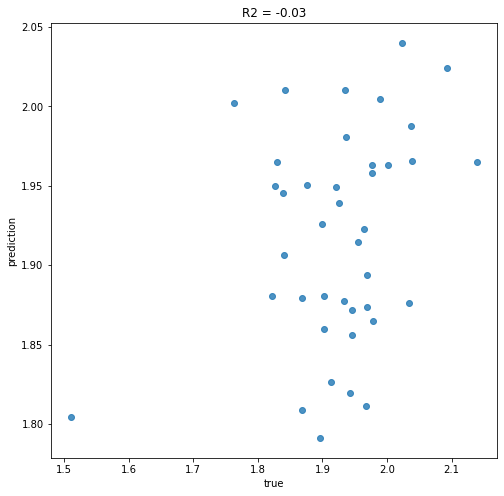

r2 : None
cor: -0.3
29.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


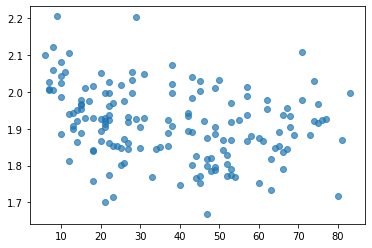

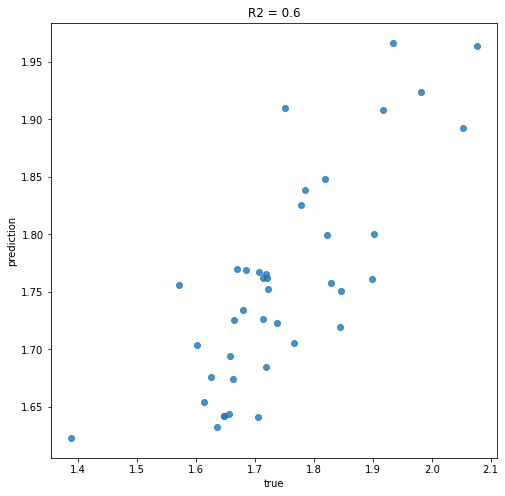

r2 : None
cor: -0.56
30.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


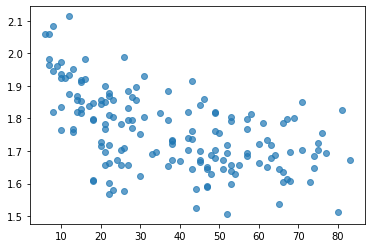

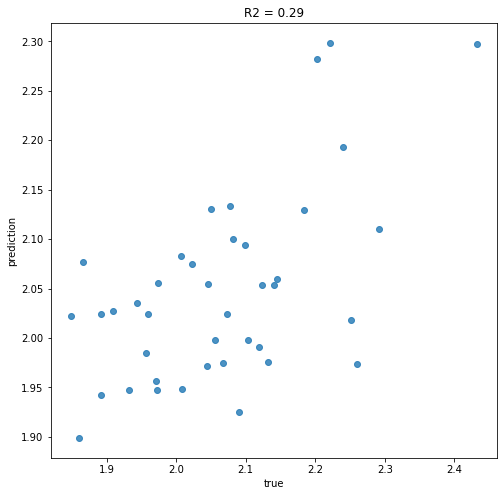

r2 : None
cor: -0.6
31.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


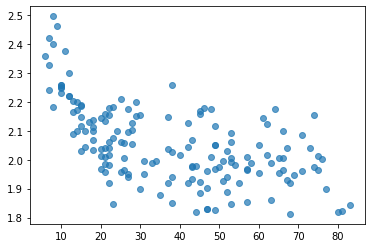

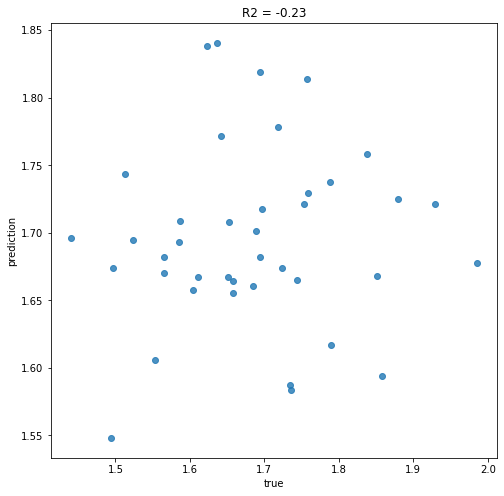

r2 : None
cor: -0.3
32.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


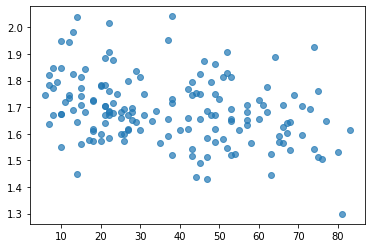

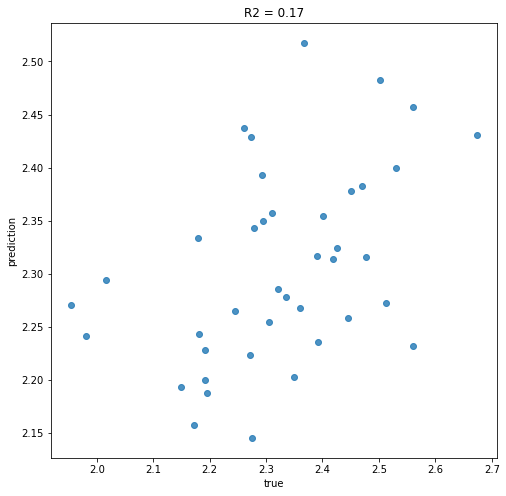

r2 : None
cor: -0.41
33.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


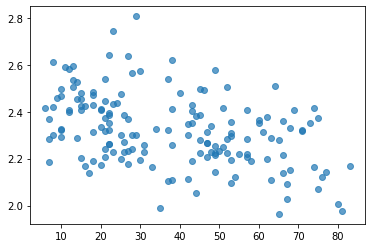

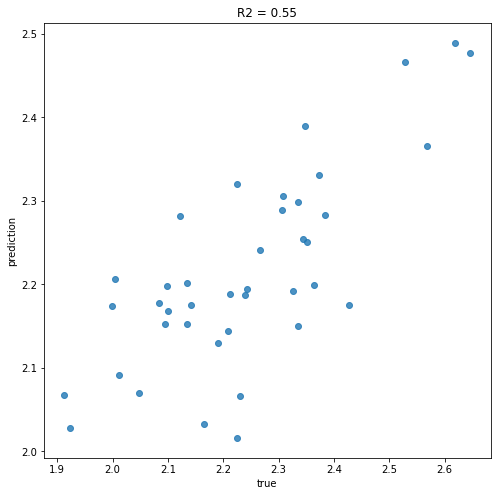

r2 : None
cor: -0.69
34.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


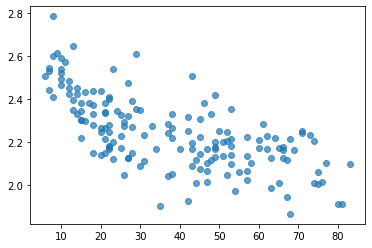

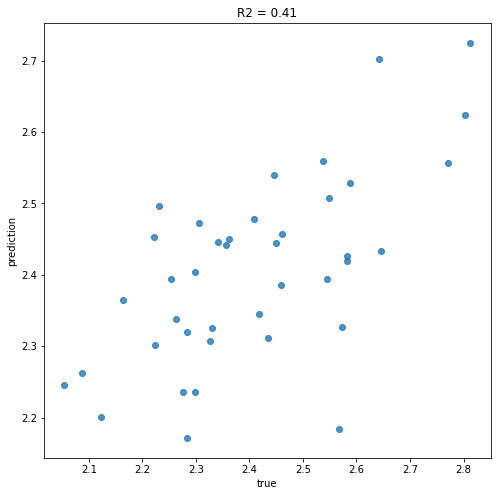

r2 : None
cor: -0.71
35.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


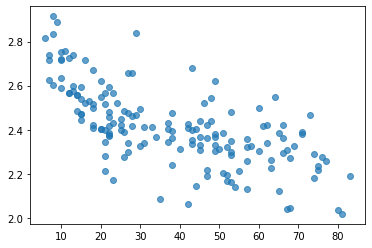

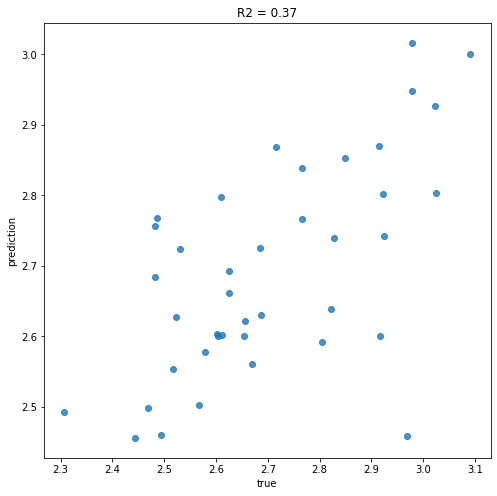

r2 : None
cor: -0.76
36.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


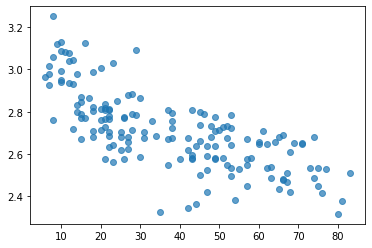

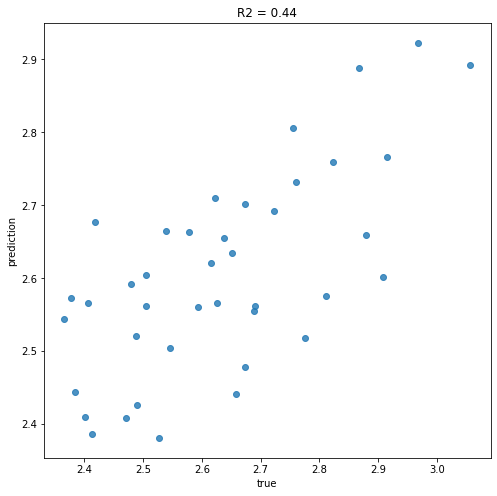

r2 : None
cor: -0.68
37.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


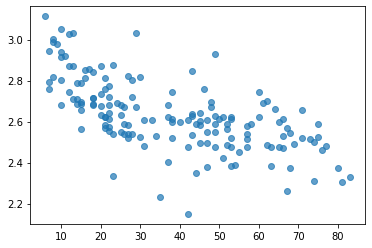

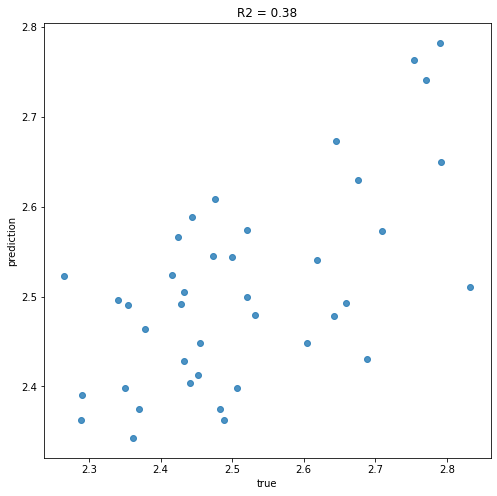

r2 : None
cor: -0.67
38.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


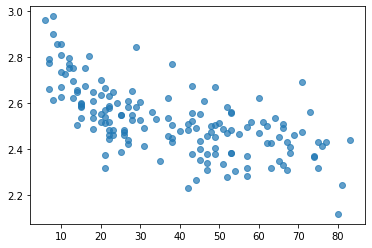

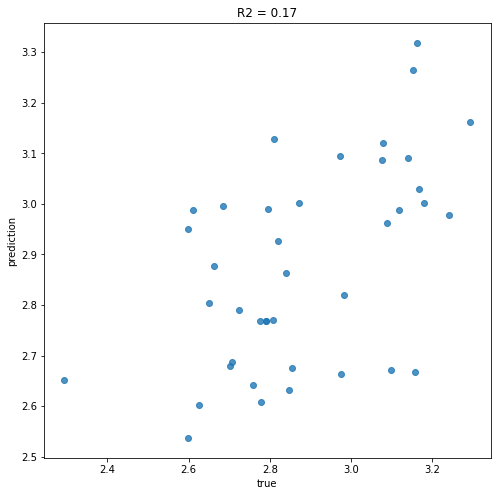

r2 : None
cor: -0.72
39.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


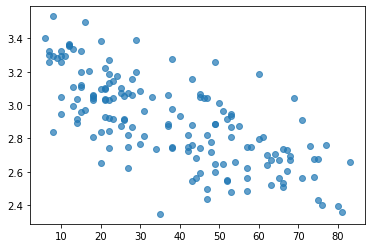

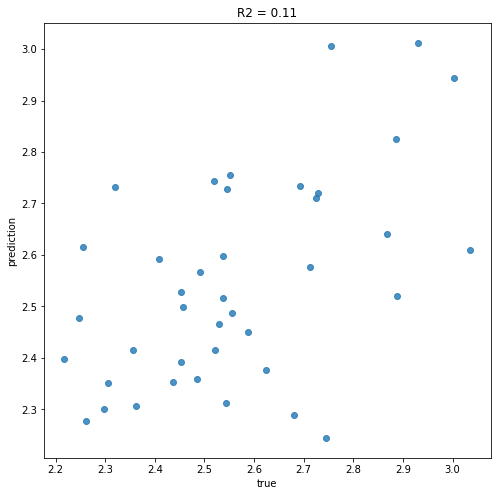

r2 : None
cor: -0.75
40.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


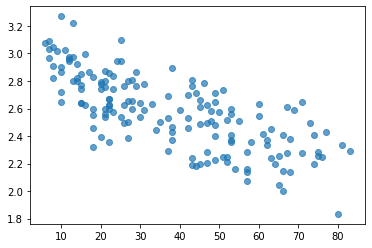

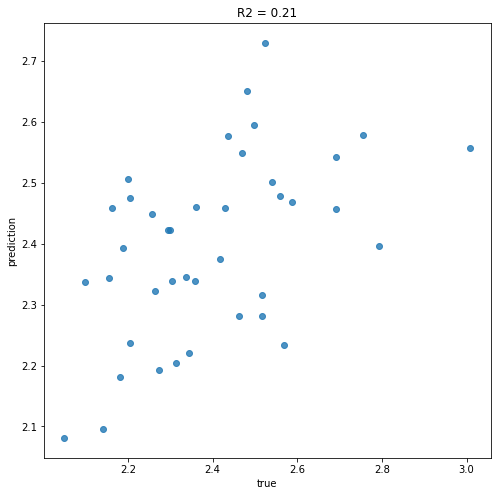

r2 : None
cor: -0.63
41.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


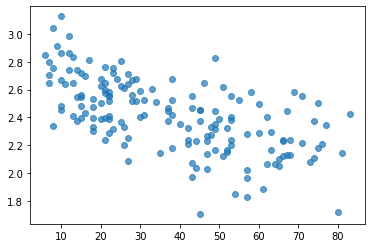

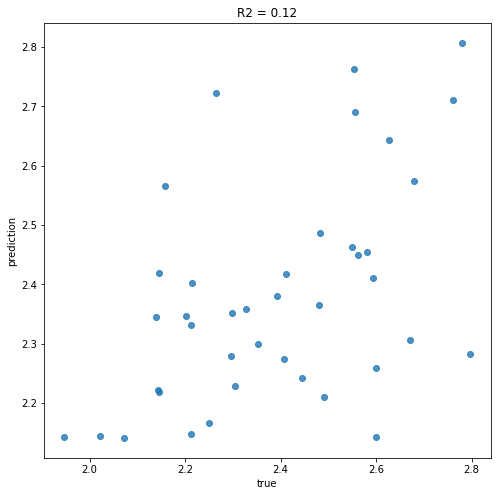

r2 : None
cor: -0.61
42.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


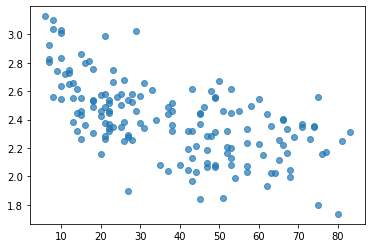

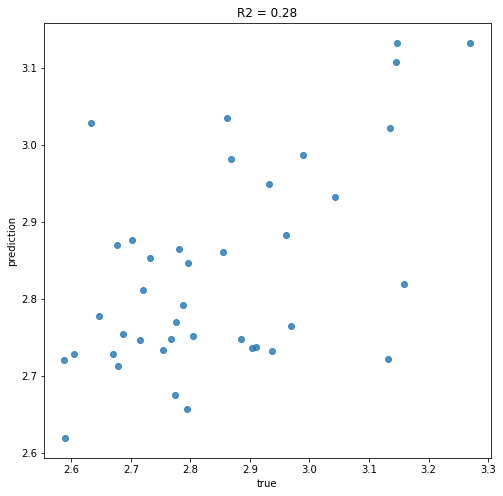

r2 : None
cor: -0.78
43.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


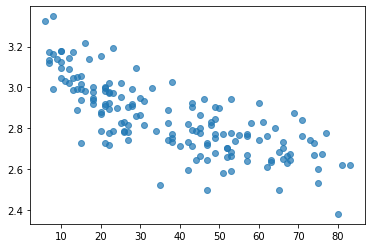

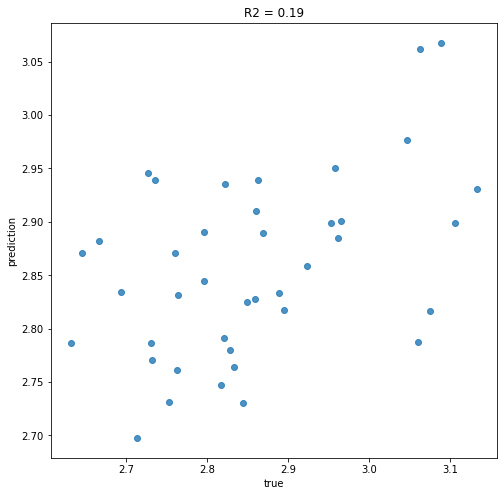

r2 : None
cor: -0.55
44.0
- Features: age, area, curv, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6



Boolean Series key will be reindexed to match DataFrame index.


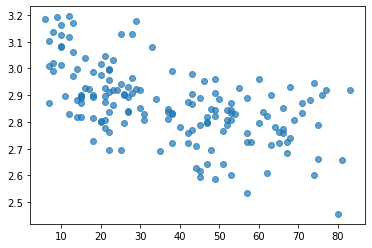

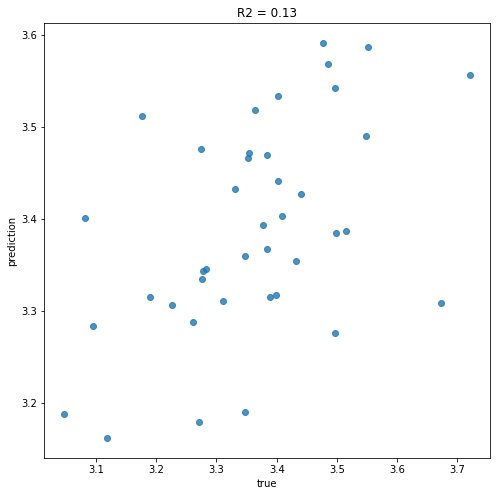

r2 : None
cor: -0.33


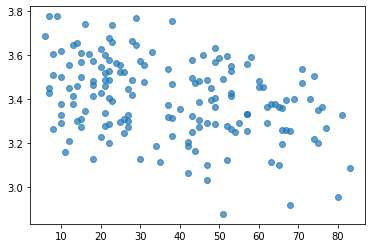

In [27]:
for structure in np.sort(X_train_gr.atlasEcono.unique()):
    print(structure)
    print('r2 : '+str(
        model(voxel = False,
          structure_selection = structure,
          features = ['age'] + geometrics + bb3, 
          scatter = True,
          expli = False,
          resume = False)
    ))
    index = X_train_gr.atlasEcono == structure
    print('cor: '+str(round(X_train_gr[index].age.corr(y_train_gr[index], method='spearman'),2)))
    
    plt.scatter(X_train_gr[index].age, y_train_gr[index], alpha=0.7)

## Rascunho

### Hyperparameter Tuning

In [4]:
# sample
participants_list = Xy.participant.unique()
participants_test = random.sample(list(participants_list), 30)
sample = Xy[Xy.participant.isin(participants_test)]

# test list
participants_list = sample.participant.unique()
n_test = int(len(participants_list)*0.3)
participants_test = random.sample(list(participants_list), n_test)

# train test split
Xy_test = Xy[Xy.participant.isin(participants_test)]
Xy_train = Xy[~Xy.participant.isin(participants_test)]

# y split
y_train = Xy_train.thickness
y_test = Xy_test.thickness

In [ ]:
# Creating features set
features_set = [
    [main + geometrics + basic_dummies + structure_dummies + bb1+bb3],
    [main + geometrics + basic_dummies + structure_dummies + bb2+bb4],
    [main + geometrics + basic_dummies + structure_dummies + bb1+bb3+bb2+bb4],
    [main + basic_dummies + structure_dummies + bb1+bb3],
    [main + basic_dummies + structure_dummies + bb2+bb4],
    [main + basic_dummies + structure_dummies + bb1+bb3+bb2+bb4],
    [main + geometrics + basic_dummies + bb1+bb3],
    [main + geometrics + basic_dummies + bb2+bb4],
    [main + geometrics + basic_dummies + bb1+bb3+bb2+bb4],
    [main + basic_dummies + bb1+bb3],
    [main + basic_dummies + bb2+bb4],
    [main + basic_dummies + bb1+bb3+bb2+bb4],
    [main + geometrics + basic_dummies + structure_dummies],
    [main + basic_dummies]
]

# Instantiate model
lgmb = LGBMRegressor()
search = []

for features in features_set[:1]:
    # Record the current time 
    start = time()
    
    # specify distributions to sample from
    param_dist = {'num_leaves': list(range(10, 3000, 100)), #
                  'max_depth': list(range(4,20,2)), #
                  'learning_rate': list(np.arange(0.01, 0.3, 0.02)), #
                  'n_estimators': [100,1000,10000], #
                  'min_split_gain': list(range(0,20,2)), #
                  'reg_alpha':list(range(0,100,10)), #
                  'reg_lambda':list(range(0,100,10)), #
                 }

    # Instantiate RandomSearchCV
    model_random_search = RandomizedSearchCV(estimator=lgmb,
                                             param_distributions=param_dist,
                                             scoring='r2_score',
                                             n_jobs=30,
                                             n_iter=20)



    # Fit the selected model
    search = model_random_search.fit(Xy_train[features[0]], y_train)
    
    # Print the time spend and number of models ran
    print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings for dataset %d." 
      % ((time() - start), len(model_random_search.cv_results_['params']), features))
    
    search.apend([features,search.cv_results_])

In [ ]:
features_replication = ['age','sex_FEMALE']

reg_g_r = LGBMRegressor(n_jobs=30).fit(X_train_gr[features_replication], y_train_gr)
y_pred_g_r = reg_g_r.predict(X_test_gr[features_replication])

plt.figure(figsize=[8,8])
plt.title('Modelo com Agrupamento Replica: R2 = '+str(round(r2_score(y_test_gr, y_pred_g_r),2)))
plt.scatter(y_test_gr, y_pred_g_r,alpha = 0.5)